In [4]:
#importing all necessary libraries
import os
import sklearn
import tensorflow as tf
from tensorflow import keras
import cv2
from pathlib import Path 
import numpy as np
import PIL

In [11]:

#opening datasets directory
p = Path('./Meat')

#counting the total number of images available in the dataset
len(list(p.glob('*/*/*.jpg')))

2266

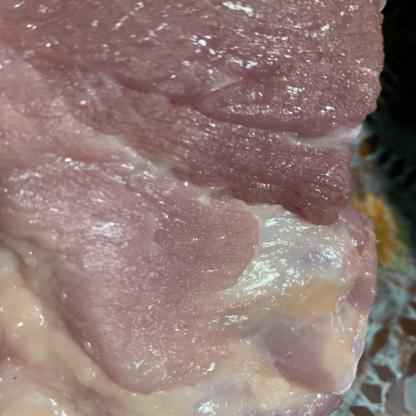

In [12]:
#fresh meat folder
fresh=list(p.glob('*/Fresh/*.jpg'))

#opening one of the images of fresh meat
PIL.Image.open(str(fresh[0]))

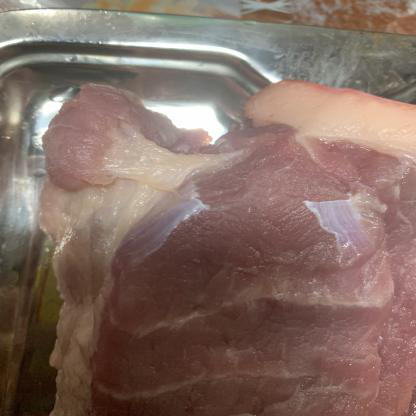

In [13]:
#half-fresh meat folder
half_fresh=list(p.glob('*/Half Fresh/*.jpg'))

#opening one of the images of half fresh meat
PIL.Image.open(str(half_fresh[0]))

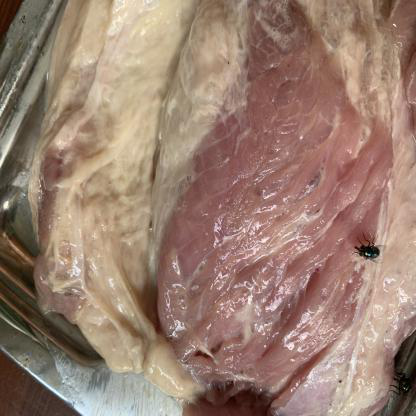

In [14]:
#spoiled meat folder
spoiled=list(p.glob('*/Spoiled/*.jpg'))

#opening one of the images of half fresh meat
PIL.Image.open(str(spoiled[0]))

In [15]:
#data augmentation
from keras.preprocessing.image import ImageDataGenerator
# Create an instance of the ImageDataGenerator
trainDatagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=0.3,
    shear_range=0.2,
    zoom_range=0.4,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

In [16]:
batch_size=32

In [17]:
trainData = trainDatagen.flow_from_directory(
    directory='./Meat/train',
    class_mode='sparse',
    target_size=(224,224),
    batch_size=64
)

Found 1880 images belonging to 3 classes.


In [18]:
trainData.class_indices

{'Fresh': 0, 'Half Fresh': 1, 'Spoiled': 2}

In [19]:
testDatagen = ImageDataGenerator(rescale=1.0/255)
testData = testDatagen.flow_from_directory(
    directory='./Meat/test',
    class_mode='sparse',
    target_size=(224,224),
    batch_size=64
)

Found 235 images belonging to 3 classes.


In [20]:
validDatagen = ImageDataGenerator(rescale=1.0/255)
validData = validDatagen.flow_from_directory(
    directory='./Meat/valid',
    class_mode='sparse',
    target_size=(224,224),
    batch_size=64
)

Found 151 images belonging to 3 classes.


In [21]:
from tensorflow.keras.applications.vgg16 import VGG16

# Load the pre-trained VGG16 model without the top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the weights of the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 27s 0us/step


In [22]:
model = keras.models.Sequential([
    # keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    # keras.layers.MaxPooling2D(),
    # keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    # keras.layers.MaxPooling2D(),
    # keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    # keras.layers.MaxPooling2D(),
    # keras.layers.Dropout(0.2),
    base_model,
    keras.layers.Flatten(),

    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(3, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 32)                4

In [23]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [24]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# Define callbacks
checkpoint = ModelCheckpoint('model_checkpoint.h5', save_best_only=True, monitor="val_accuracy", verbose=1)
early_stopping = EarlyStopping(monitor="val_accuracy", min_delta=0.01, patience=5, verbose=1)

In [25]:
r=model.fit(trainData, validation_data=validData, validation_steps=validData.samples // batch_size, steps_per_epoch=trainData.samples // batch_size, epochs=1, verbose =1, callbacks=[early_stopping, checkpoint])

 1/58 [..............................] - ETA: 21:38 - loss: 1.2158 - accuracy: 0.3594

KeyboardInterrupt: 

In [ ]:
plt.plot(r.history['accuracy'])
plt.plot(r.history['val_accuracy'])
plt.title('Classification Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

# Plot training & validation loss values
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()